# Reuters-21578 Dataset Exploration
## Stopword Impact Analysis - Data Exploration

This notebook performs comprehensive exploratory data analysis on the Reuters-21578 dataset.

**Analyses Covered:**
1. Dataset statistics (number of articles, topics, date range)
2. Topic distribution
3. Text length distribution
4. Word frequency analysis
5. Stopword presence analysis

## Setup and Imports

In [16]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from pathlib import Path
import warnings
import os
import sys

warnings.filterwarnings('ignore')

# NLTK imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
print("Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Set style for better visualizations
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('default')
    
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Load Data

In [17]:
# Load the processed Reuters data
# Assuming data_loader.py has been run and created the CSV
data_path = Path('../data/processed/reuters_raw.csv')

if not data_path.exists():
    print("⚠️ Data file not found. Running data loader first...")
    # Run the data loader
    import sys
    sys.path.append('../src')
    from preprocessing.data_loader import ReutersDataLoader
    
    loader = ReutersDataLoader('../data/raw')
    df_raw = loader.load_all_files()
    
    # Create processed directory if it doesn't exist
    Path('../data/processed').mkdir(parents=True, exist_ok=True)
    df_raw.to_csv(data_path, index=False)
    print("✓ Data loaded and saved")
else:
    df_raw = pd.read_csv(data_path)
    # Convert string representation of list back to actual list
    import ast
    df_raw['topics'] = df_raw['topics'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    print("✓ Data loaded from existing file")

print(f"\nDataset shape: {df_raw.shape}")
df_raw.head()

✓ Data loaded from existing file

Dataset shape: (21578, 5)


,newid,topics,title,body,date
0,1,[cocoa],BAHIA COCOA REVIEW,Showers continued throughout the week in\nthe ...,<date>26-FEB-1987 15:01:01.79</date>
1,2,[],STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America\nInc said...,<date>26-FEB-1987 15:02:20.00</date>
2,3,[],TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas\nCommerc...,<date>26-FEB-1987 15:03:27.51</date>
3,4,[],TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER,BankAmerica Corp is not under\npressure to act...,<date>26-FEB-1987 15:07:13.72</date>
4,5,"[grain, wheat, corn, barley, oat, sorghum]",NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...,<date>26-FEB-1987 15:10:44.60</date>


---
# 1. Dataset Statistics
## Basic Information and Summary

In [18]:
print("="*70)
print("REUTERS-21578 DATASET STATISTICS")
print("="*70)

# Basic statistics
total_articles = len(df_raw)
articles_with_topics = len(df_raw[df_raw['topics'].apply(lambda x: len(x) > 0)])
articles_without_topics = total_articles - articles_with_topics

print(f"\n📊 Article Counts:")
print(f"   Total articles: {total_articles:,}")
print(f"   Articles with topics: {articles_with_topics:,} ({articles_with_topics/total_articles*100:.1f}%)")
print(f"   Articles without topics: {articles_without_topics:,} ({articles_without_topics/total_articles*100:.1f}%)")

# Text availability
articles_with_title = len(df_raw[df_raw['title'].notna() & (df_raw['title'] != '')])
articles_with_body = len(df_raw[df_raw['body'].notna() & (df_raw['body'] != '')])
articles_with_both = len(df_raw[
    (df_raw['title'].notna() & (df_raw['title'] != '')) & 
    (df_raw['body'].notna() & (df_raw['body'] != ''))
])

print(f"\n📝 Text Availability:")
print(f"   Articles with title: {articles_with_title:,} ({articles_with_title/total_articles*100:.1f}%)")
print(f"   Articles with body: {articles_with_body:,} ({articles_with_body/total_articles*100:.1f}%)")
print(f"   Articles with both: {articles_with_both:,} ({articles_with_both/total_articles*100:.1f}%)")

# Topic statistics
all_topics = [topic for topics_list in df_raw['topics'] for topic in topics_list]
unique_topics = len(set(all_topics))
avg_topics_per_article = len(all_topics) / articles_with_topics if articles_with_topics > 0 else 0

print(f"\n🏷️ Topic Statistics:")
print(f"   Total unique topics: {unique_topics}")
print(f"   Total topic assignments: {len(all_topics):,}")
print(f"   Average topics per article: {avg_topics_per_article:.2f}")

print("\n" + "="*70)

REUTERS-21578 DATASET STATISTICS

📊 Article Counts:
   Total articles: 21,578
   Articles with topics: 11,367 (52.7%)
   Articles without topics: 10,211 (47.3%)

📝 Text Availability:
   Articles with title: 20,841 (96.6%)
   Articles with body: 19,043 (88.3%)
   Articles with both: 19,043 (88.3%)

🏷️ Topic Statistics:
   Total unique topics: 120
   Total topic assignments: 14,302
   Average topics per article: 1.26



In [19]:
# Create summary DataFrame
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Articles',
        'Articles with Topics',
        'Articles with Body Text',
        'Unique Topics',
        'Avg Topics per Article'
    ],
    'Value': [
        f"{total_articles:,}",
        f"{articles_with_topics:,} ({articles_with_topics/total_articles*100:.1f}%)",
        f"{articles_with_body:,} ({articles_with_body/total_articles*100:.1f}%)",
        f"{unique_topics}",
        f"{avg_topics_per_article:.2f}"
    ]
})

print("\nSummary Statistics Table:")
print(summary_stats.to_string(index=False))

# Save to file
Path('../results/tables').mkdir(parents=True, exist_ok=True)
summary_stats.to_csv('../results/tables/dataset_summary.csv', index=False)
print("\n✓ Summary statistics saved to results/tables/dataset_summary.csv")


Summary Statistics Table:
                 Metric          Value
         Total Articles         21,578
   Articles with Topics 11,367 (52.7%)
Articles with Body Text 19,043 (88.3%)
          Unique Topics            120
 Avg Topics per Article           1.26

✓ Summary statistics saved to results/tables/dataset_summary.csv


---
# 2. Topic Distribution Analysis
## Frequency and Distribution of Topics

In [20]:
# Count topic frequencies
topic_counts = Counter(all_topics)
topic_df = pd.DataFrame(topic_counts.items(), columns=['Topic', 'Count']).sort_values('Count', ascending=False)

print("\nTop 20 Most Frequent Topics:")
print(topic_df.head(20).to_string(index=False))

# Save topic distribution
topic_df.to_csv('../results/tables/topic_distribution.csv', index=False)
print("\n✓ Topic distribution saved to results/tables/topic_distribution.csv")


Top 20 Most Frequent Topics:
       Topic  Count
        earn   3987
         acq   2448
    money-fx    801
       crude    634
       grain    628
       trade    552
    interest    513
       wheat    306
        ship    305
        corn    254
         dlr    217
     oilseed    192
money-supply    190
       sugar    184
         gnp    163
      coffee    145
     veg-oil    137
        gold    135
     nat-gas    130
     soybean    120

✓ Topic distribution saved to results/tables/topic_distribution.csv


✓ Figure saved to results/figures/top_20_topics.png


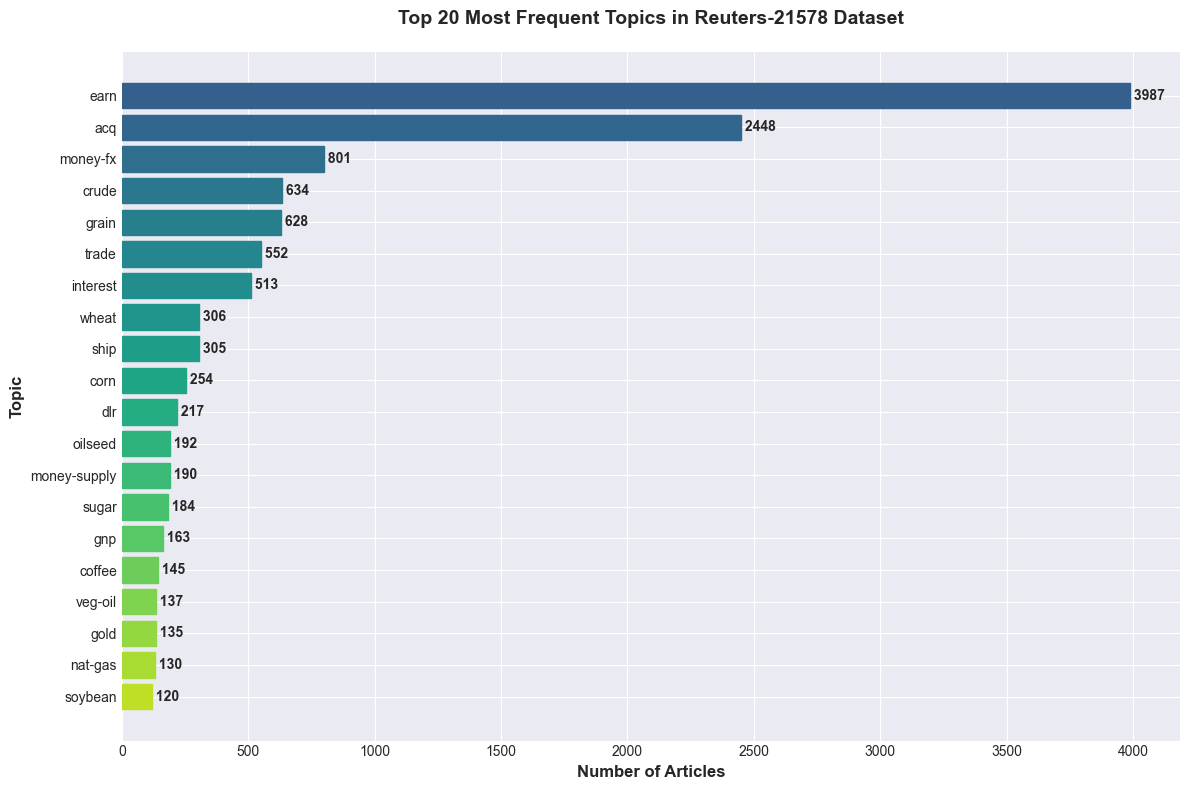

In [21]:
# Visualize top 20 topics
fig, ax = plt.subplots(figsize=(12, 8))

top_20_topics = topic_df.head(20)
bars = ax.barh(range(len(top_20_topics)), top_20_topics['Count'].values)
ax.set_yticks(range(len(top_20_topics)))
ax.set_yticklabels(top_20_topics['Topic'].values)
ax.set_xlabel('Number of Articles', fontsize=12, fontweight='bold')
ax.set_ylabel('Topic', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Most Frequent Topics in Reuters-21578 Dataset', 
             fontsize=14, fontweight='bold', pad=20)

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, 
            f' {int(width)}', 
            ha='left', va='center', fontweight='bold')

# Color bars by gradient
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.invert_yaxis()  # Highest at top
plt.tight_layout()

# Save figure
Path('../results/figures').mkdir(parents=True, exist_ok=True)
plt.savefig('../results/figures/top_20_topics.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to results/figures/top_20_topics.png")
plt.show()

✓ Figure saved to results/figures/topic_frequency_distribution.png


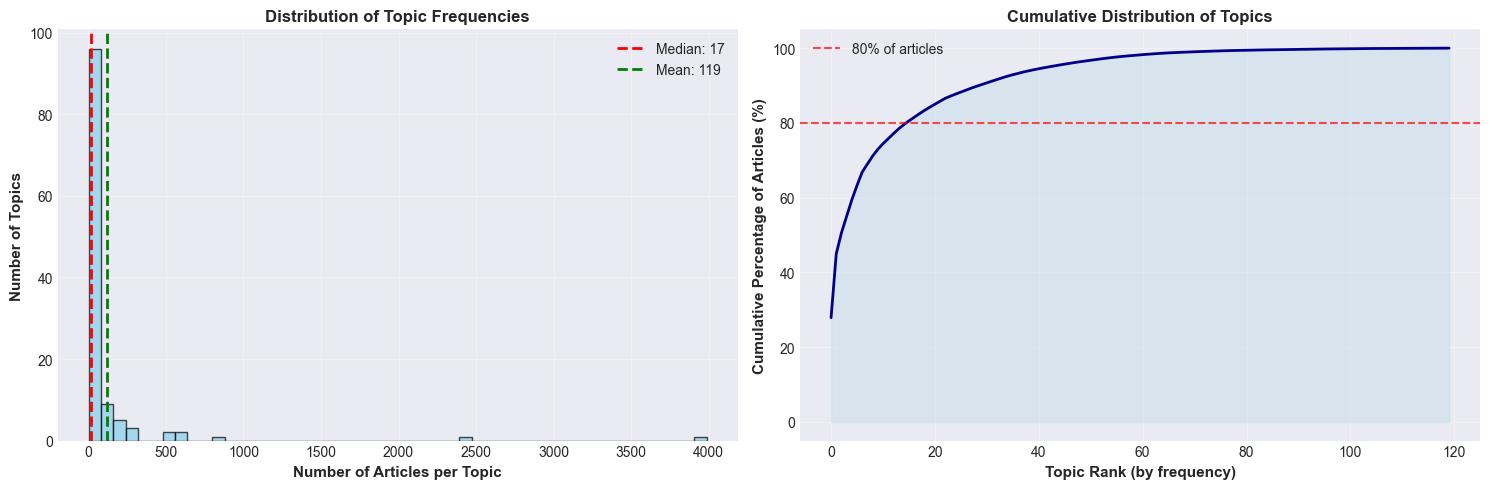


📊 Insight: Top 15 topics (out of 120) account for 80% of all articles


In [22]:
# Topic frequency distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of topic frequencies
axes[0].hist(topic_df['Count'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Articles per Topic', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Number of Topics', fontsize=11, fontweight='bold')
axes[0].set_title('Distribution of Topic Frequencies', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(topic_df['Count'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: {topic_df['Count'].median():.0f}")
axes[0].axvline(topic_df['Count'].mean(), color='green', linestyle='--', linewidth=2, label=f"Mean: {topic_df['Count'].mean():.0f}")
axes[0].legend()

# Cumulative distribution
sorted_counts = topic_df['Count'].sort_values(ascending=False).reset_index(drop=True)
cumulative_pct = (sorted_counts.cumsum() / sorted_counts.sum()) * 100

axes[1].plot(range(len(cumulative_pct)), cumulative_pct, linewidth=2, color='darkblue')
axes[1].fill_between(range(len(cumulative_pct)), cumulative_pct, alpha=0.3, color='lightblue')
axes[1].set_xlabel('Topic Rank (by frequency)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Cumulative Percentage of Articles (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Cumulative Distribution of Topics', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(80, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='80% of articles')
axes[1].legend()

plt.tight_layout()
plt.savefig('../results/figures/topic_frequency_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to results/figures/topic_frequency_distribution.png")
plt.show()

# Print insights
topics_80_pct = len(cumulative_pct[cumulative_pct <= 80])
print(f"\n📊 Insight: Top {topics_80_pct} topics (out of {len(topic_df)}) account for 80% of all articles")

In [23]:
# Filter topics with minimum document count for classification
min_docs = 20
frequent_topics = topic_df[topic_df['Count'] >= min_docs]

print(f"\n🎯 Topics with at least {min_docs} documents: {len(frequent_topics)}")
print(f"   This covers {frequent_topics['Count'].sum():,} articles ({frequent_topics['Count'].sum()/len(all_topics)*100:.1f}% of all topic assignments)")
print("\nTop 10 Frequent Topics for Classification:")
print(frequent_topics.head(10).to_string(index=False))


🎯 Topics with at least 20 documents: 57
   This covers 13,984 articles (97.8% of all topic assignments)

Top 10 Frequent Topics for Classification:
   Topic  Count
    earn   3987
     acq   2448
money-fx    801
   crude    634
   grain    628
   trade    552
interest    513
   wheat    306
    ship    305
    corn    254


---
# 3. Text Length Distribution
## Analysis of Article Length Characteristics

In [24]:
# Calculate text lengths
df_analysis = df_raw.copy()

# Title lengths
df_analysis['title_length'] = df_analysis['title'].fillna('').apply(len)
df_analysis['title_word_count'] = df_analysis['title'].fillna('').apply(lambda x: len(x.split()))

# Body lengths
df_analysis['body_length'] = df_analysis['body'].fillna('').apply(len)
df_analysis['body_word_count'] = df_analysis['body'].fillna('').apply(lambda x: len(x.split()))

# Combined lengths
df_analysis['total_length'] = df_analysis['title_length'] + df_analysis['body_length']
df_analysis['total_word_count'] = df_analysis['title_word_count'] + df_analysis['body_word_count']

# Filter to articles with body text for meaningful analysis
df_with_text = df_analysis[df_analysis['body_length'] > 0].copy()

print("\nText Length Statistics:")
print("="*70)

stats_df = pd.DataFrame({
    'Metric': ['Character Count', 'Word Count'],
    'Mean': [
        f"{df_with_text['body_length'].mean():.0f}",
        f"{df_with_text['body_word_count'].mean():.0f}"
    ],
    'Median': [
        f"{df_with_text['body_length'].median():.0f}",
        f"{df_with_text['body_word_count'].median():.0f}"
    ],
    'Std Dev': [
        f"{df_with_text['body_length'].std():.0f}",
        f"{df_with_text['body_word_count'].std():.0f}"
    ],
    'Min': [
        f"{df_with_text['body_length'].min():.0f}",
        f"{df_with_text['body_word_count'].min():.0f}"
    ],
    'Max': [
        f"{df_with_text['body_length'].max():.0f}",
        f"{df_with_text['body_word_count'].max():.0f}"
    ]
})

print(stats_df.to_string(index=False))
print("="*70)

# Save statistics
stats_df.to_csv('../results/tables/text_length_statistics.csv', index=False)
print("\n✓ Text length statistics saved to results/tables/text_length_statistics.csv")


Text Length Statistics:
         Metric Mean Median Std Dev Min   Max
Character Count  836    553     847   6 13397
     Word Count  136     90     135   2  1669

✓ Text length statistics saved to results/tables/text_length_statistics.csv


✓ Figure saved to results/figures/text_length_distribution.png


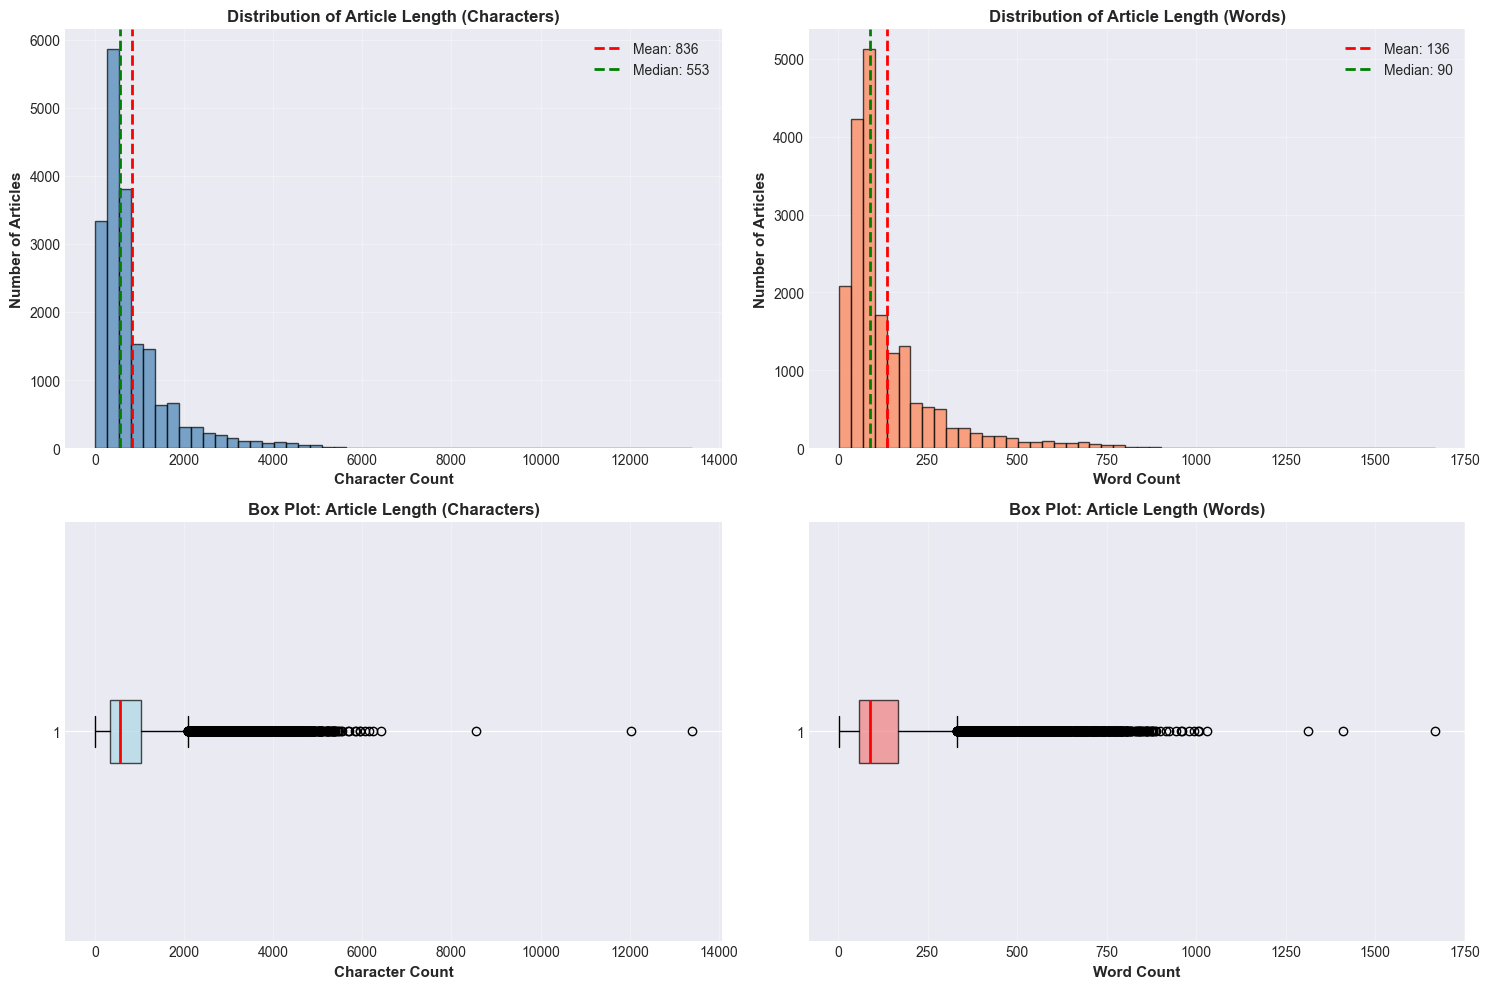

In [25]:
# Visualize text length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Character count histogram
axes[0, 0].hist(df_with_text['body_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_with_text['body_length'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {df_with_text['body_length'].mean():.0f}")
axes[0, 0].axvline(df_with_text['body_length'].median(), color='green', linestyle='--', 
                   linewidth=2, label=f"Median: {df_with_text['body_length'].median():.0f}")
axes[0, 0].set_xlabel('Character Count', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Number of Articles', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribution of Article Length (Characters)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Word count histogram
axes[0, 1].hist(df_with_text['body_word_count'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df_with_text['body_word_count'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {df_with_text['body_word_count'].mean():.0f}")
axes[0, 1].axvline(df_with_text['body_word_count'].median(), color='green', linestyle='--', 
                   linewidth=2, label=f"Median: {df_with_text['body_word_count'].median():.0f}")
axes[0, 1].set_xlabel('Word Count', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Number of Articles', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Distribution of Article Length (Words)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Box plot for character count
axes[1, 0].boxplot(df_with_text['body_length'], vert=False, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
axes[1, 0].set_xlabel('Character Count', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Box Plot: Article Length (Characters)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Box plot for word count
axes[1, 1].boxplot(df_with_text['body_word_count'], vert=False, patch_artist=True,
                   boxprops=dict(facecolor='lightcoral', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
axes[1, 1].set_xlabel('Word Count', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Box Plot: Article Length (Words)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../results/figures/text_length_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to results/figures/text_length_distribution.png")
plt.show()

✓ Figure saved to results/figures/length_categories.png


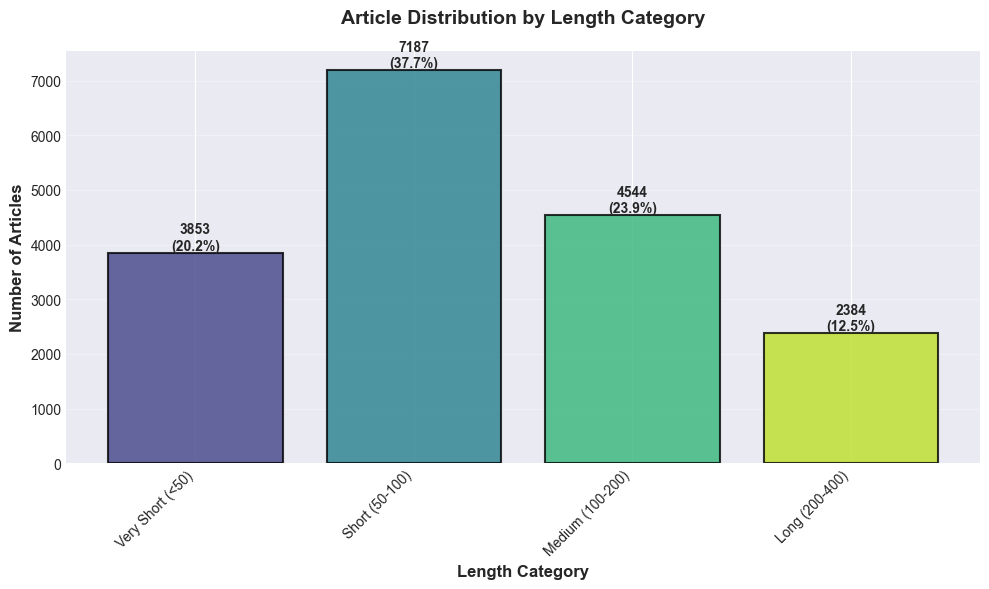


📊 Article Length Categories:
   Very Short (<50): 3,853 articles (20.2%)
   Short (50-100): 7,187 articles (37.7%)
   Medium (100-200): 4,544 articles (23.9%)
   Long (200-400): 2,384 articles (12.5%)


In [26]:
# Categorize articles by length
def categorize_length(word_count):
    """Categorize article by word count"""
    if pd.isna(word_count) or word_count == 0:
        return None
    if word_count < 50:
        return 'Very Short (<50)'
    elif word_count < 100:
        return 'Short (50-100)'
    elif word_count < 200:
        return 'Medium (100-200)'
    elif word_count < 400:
        return 'Long (200-400)'
    else:
        return 'Very Long (400+)'

df_with_text['length_category'] = df_with_text['body_word_count'].apply(categorize_length)

# Count by category (excluding None)
length_category_counts = df_with_text['length_category'].value_counts()
category_order = ['Very Short (<50)', 'Short (50-100)', 'Medium (100-200)', 'Long (200-400)', 'Very Long (400+']

# Only keep categories that exist in the data
category_order = [cat for cat in category_order if cat in length_category_counts.index]
length_category_counts = length_category_counts.reindex(category_order, fill_value=0)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(length_category_counts)), length_category_counts.values, 
              color=plt.cm.viridis(np.linspace(0.2, 0.9, len(length_category_counts))),
              edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_xticks(range(len(length_category_counts)))
ax.set_xticklabels(length_category_counts.index, rotation=45, ha='right')
ax.set_ylabel('Number of Articles', fontsize=12, fontweight='bold')
ax.set_xlabel('Length Category', fontsize=12, fontweight='bold')
ax.set_title('Article Distribution by Length Category', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    if not np.isnan(height) and height > 0:
        percentage = (height / len(df_with_text)) * 100
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('../results/figures/length_categories.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to results/figures/length_categories.png")
plt.show()

print("\n📊 Article Length Categories:")
for cat, count in length_category_counts.items():
    if count > 0:
        print(f"   {cat}: {count:,} articles ({count/len(df_with_text)*100:.1f}%)")

---
# 4. Word Frequency Analysis
## Most Common Words and Vocabulary Statistics

In [27]:
# Tokenize all text
print("Tokenizing text corpus... (this may take a minute)")

all_words = []
for text in df_with_text['body'].dropna():
    # Simple tokenization (lowercase and split)
    words = re.findall(r'\b[a-z]+\b', text.lower())
    all_words.extend(words)

print(f"✓ Tokenization complete")
print(f"\n📝 Vocabulary Statistics:")
print(f"   Total words: {len(all_words):,}")
print(f"   Unique words: {len(set(all_words)):,}")
print(f"   Average word length: {np.mean([len(w) for w in all_words]):.2f} characters")

Tokenizing text corpus... (this may take a minute)
✓ Tokenization complete

📝 Vocabulary Statistics:
   Total words: 2,490,826
   Unique words: 38,858
   Average word length: 4.84 characters


In [28]:
# Count word frequencies
word_freq = Counter(all_words)
word_freq_df = pd.DataFrame(word_freq.most_common(100), columns=['Word', 'Frequency'])

print("\nTop 30 Most Frequent Words:")
print(word_freq_df.head(30).to_string(index=False))

# Save word frequencies
word_freq_df.to_csv('../results/tables/word_frequencies.csv', index=False)
print("\n✓ Word frequencies saved to results/tables/word_frequencies.csv")


Top 30 Most Frequent Words:
   Word  Frequency
    the     144339
     of      72347
     to      68943
    and      53923
   said      52915
     in      52672
      a      51837
      s      29975
    for      26053
    mln      25565
     it      22639
   dlrs      20569
 reuter      18945
     on      18435
    pct      17068
     is      16791
   that      15517
   from      14982
    its      14909
     by      14743
   will      14683
     vs      14585
     be      14571
     at      14046
   with      13313
   year      12452
    was      11923
     he      10626
billion      10257
    has       9912

✓ Word frequencies saved to results/tables/word_frequencies.csv


✓ Figure saved to results/figures/top_30_words.png


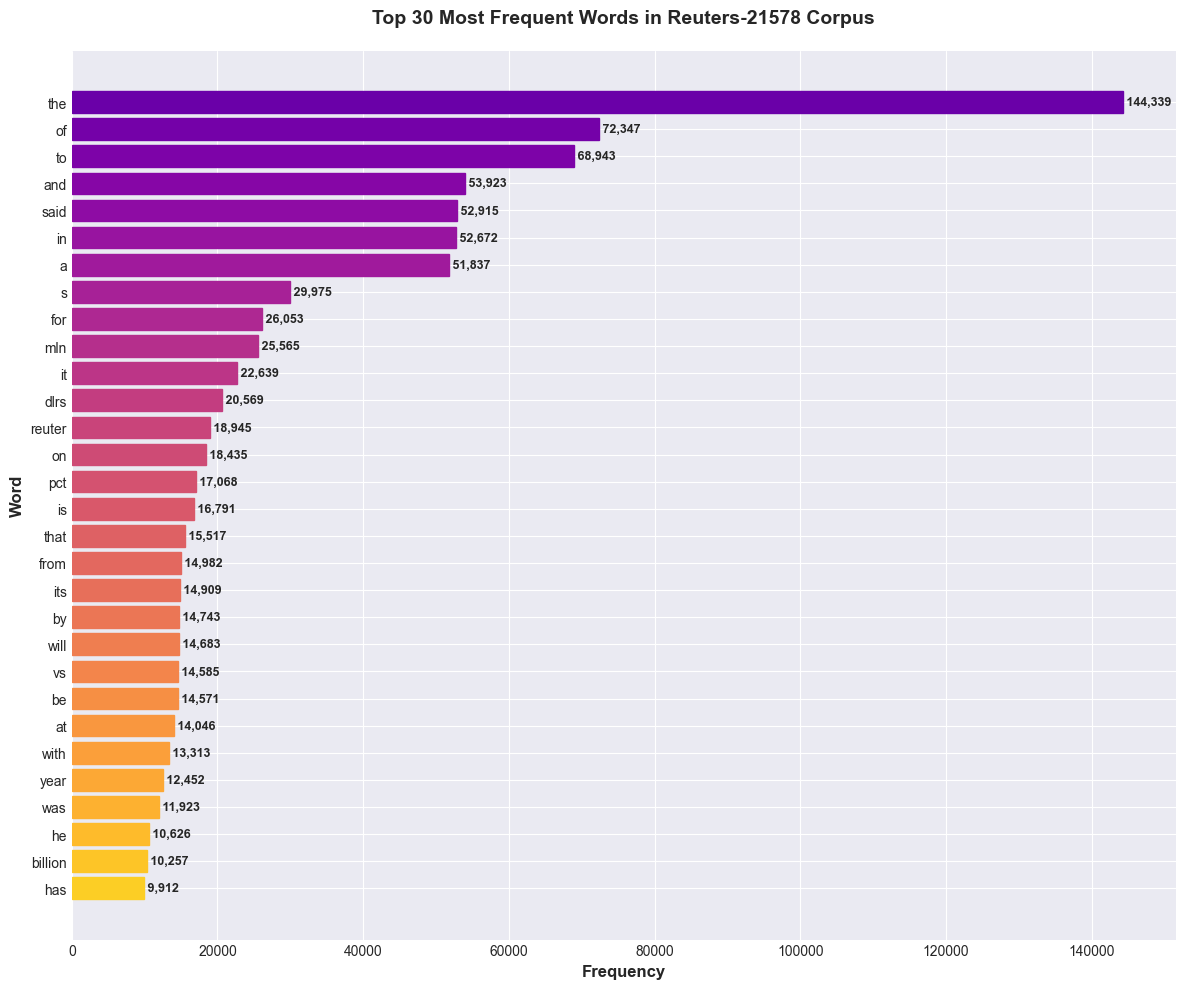

In [29]:
# Visualize top 30 words
fig, ax = plt.subplots(figsize=(12, 10))

top_30_words = word_freq_df.head(30)
bars = ax.barh(range(len(top_30_words)), top_30_words['Frequency'].values)
ax.set_yticks(range(len(top_30_words)))
ax.set_yticklabels(top_30_words['Word'].values)
ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
ax.set_ylabel('Word', fontsize=12, fontweight='bold')
ax.set_title('Top 30 Most Frequent Words in Reuters-21578 Corpus', 
             fontsize=14, fontweight='bold', pad=20)

# Color gradient
colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Add frequency labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, 
            f' {int(width):,}', 
            ha='left', va='center', fontweight='bold', fontsize=9)

ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../results/figures/top_30_words.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to results/figures/top_30_words.png")
plt.show()

✓ Figure saved to results/figures/zipf_law.png


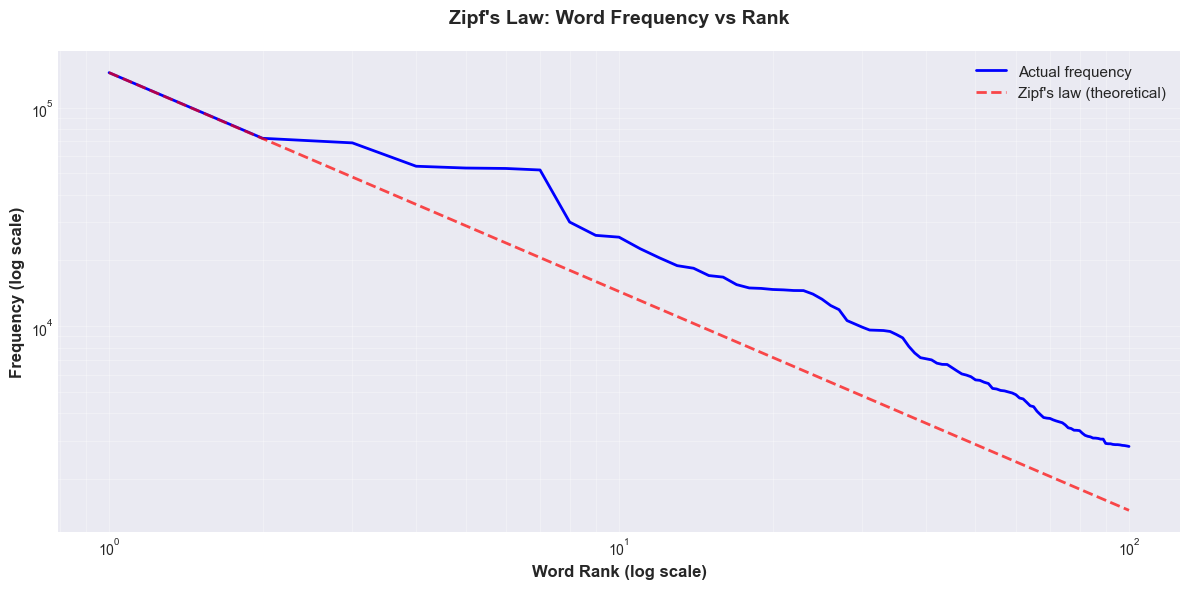


📊 Zipf's Law Observation:
   The actual word frequency distribution closely follows Zipf's law,
   indicating natural language characteristics in the Reuters corpus.


In [30]:
# Zipf's Law analysis
fig, ax = plt.subplots(figsize=(12, 6))

ranks = np.arange(1, len(word_freq_df) + 1)
frequencies = word_freq_df['Frequency'].values

ax.loglog(ranks, frequencies, 'b-', linewidth=2, label='Actual frequency')

# Theoretical Zipf's law line
zipf_theoretical = frequencies[0] / ranks
ax.loglog(ranks, zipf_theoretical, 'r--', linewidth=2, alpha=0.7, label="Zipf's law (theoretical)")

ax.set_xlabel('Word Rank (log scale)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency (log scale)', fontsize=12, fontweight='bold')
ax.set_title("Zipf's Law: Word Frequency vs Rank", fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('../results/figures/zipf_law.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to results/figures/zipf_law.png")
plt.show()

print("\n📊 Zipf's Law Observation:")
print("   The actual word frequency distribution closely follows Zipf's law,")
print("   indicating natural language characteristics in the Reuters corpus.")

---
# 5. Stopword Presence Analysis
## Analysis of Stopword Distribution and Impact

In [31]:
# Get NLTK stopwords
english_stopwords = set(stopwords.words('english'))

print(f"📚 NLTK English Stopwords: {len(english_stopwords)} words")
print(f"\nSample stopwords: {list(english_stopwords)[:20]}")

📚 NLTK English Stopwords: 198 words

Sample stopwords: ['now', 'them', 'very', "we'll", 'you', 'needn', 'she', 'his', 'further', 'over', 'doesn', 'no', 'each', 'weren', 'which', 'once', 'couldn', "shouldn't", "needn't", 'below']


In [32]:
# Analyze stopword presence
stopword_count = sum(1 for word in all_words if word in english_stopwords)
non_stopword_count = len(all_words) - stopword_count
stopword_percentage = (stopword_count / len(all_words)) * 100

print("\n🔍 Stopword Analysis Results:")
print("="*70)
print(f"Total words in corpus: {len(all_words):,}")
print(f"Stopwords: {stopword_count:,} ({stopword_percentage:.2f}%)")
print(f"Non-stopwords: {non_stopword_count:,} ({100-stopword_percentage:.2f}%)")
print("="*70)

# Most frequent stopwords
stopword_freq = {word: count for word, count in word_freq.items() if word in english_stopwords}
stopword_freq_df = pd.DataFrame(
    sorted(stopword_freq.items(), key=lambda x: x[1], reverse=True)[:30],
    columns=['Stopword', 'Frequency']
)

print("\nTop 30 Most Frequent Stopwords:")
print(stopword_freq_df.to_string(index=False))

# Save stopword analysis
stopword_freq_df.to_csv('../results/tables/stopword_frequencies.csv', index=False)
print("\n✓ Stopword frequencies saved to results/tables/stopword_frequencies.csv")


🔍 Stopword Analysis Results:
Total words in corpus: 2,490,826
Stopwords: 915,202 (36.74%)
Non-stopwords: 1,575,624 (63.26%)

Top 30 Most Frequent Stopwords:
Stopword  Frequency
     the     144339
      of      72347
      to      68943
     and      53923
      in      52672
       a      51837
       s      29975
     for      26053
      it      22639
      on      18435
      is      16791
    that      15517
    from      14982
     its      14909
      by      14743
    will      14683
      be      14571
      at      14046
    with      13313
     was      11923
      he      10626
     has       9912
      as       9596
      an       9571
     not       8099
   which       7556
     but       7110
     are       7029
    this       6789
    have       6704

✓ Stopword frequencies saved to results/tables/stopword_frequencies.csv


✓ Figure saved to results/figures/stopword_analysis.png


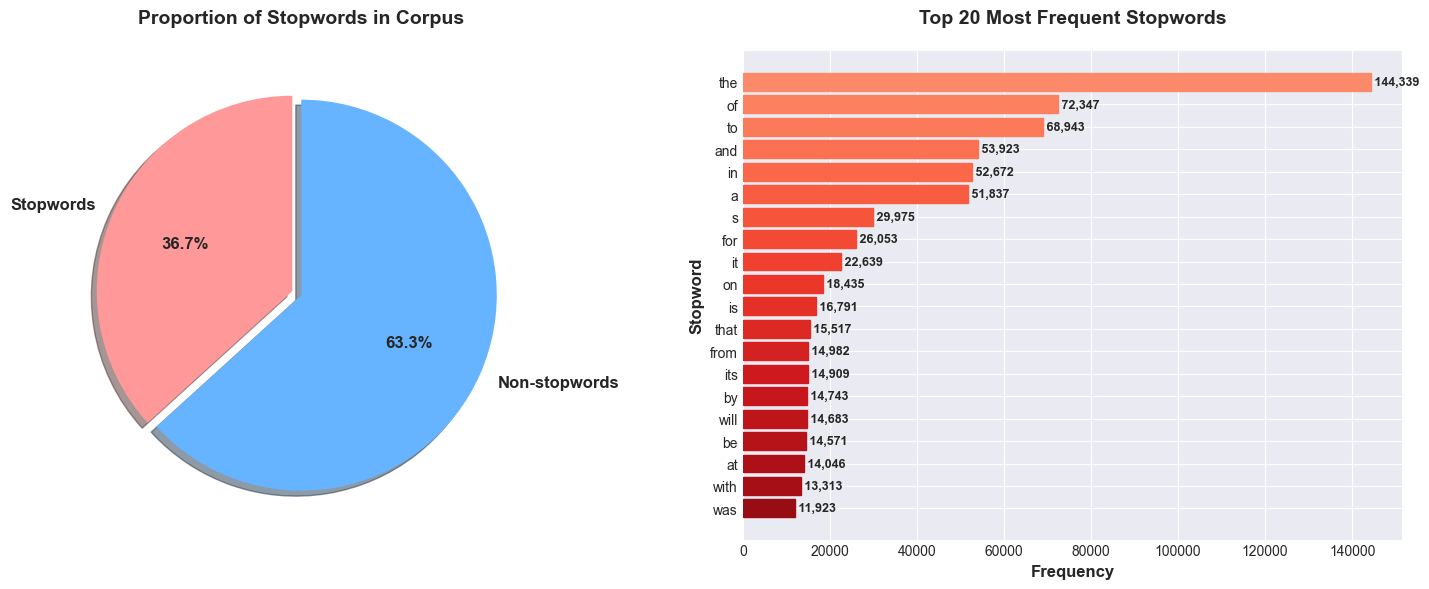

In [33]:
# Visualize stopword vs non-stopword distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
colors_pie = ['#ff9999', '#66b3ff']
explode = (0.05, 0)
axes[0].pie([stopword_count, non_stopword_count], 
            labels=['Stopwords', 'Non-stopwords'],
            autopct='%1.1f%%', 
            colors=colors_pie,
            explode=explode,
            shadow=True,
            startangle=90,
            textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('Proportion of Stopwords in Corpus', fontsize=14, fontweight='bold', pad=20)

# Bar chart of top stopwords
top_20_stopwords = stopword_freq_df.head(20)
bars = axes[1].barh(range(len(top_20_stopwords)), top_20_stopwords['Frequency'].values)
axes[1].set_yticks(range(len(top_20_stopwords)))
axes[1].set_yticklabels(top_20_stopwords['Stopword'].values)
axes[1].set_xlabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Stopword', fontsize=12, fontweight='bold')
axes[1].set_title('Top 20 Most Frequent Stopwords', fontsize=14, fontweight='bold', pad=20)

# Color gradient for bars
colors_bar = plt.cm.Reds(np.linspace(0.4, 0.9, len(bars)))
for bar, color in zip(bars, colors_bar):
    bar.set_color(color)

# Add frequency labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[1].text(width, bar.get_y() + bar.get_height()/2, 
                f' {int(width):,}', 
                ha='left', va='center', fontweight='bold', fontsize=9)

axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../results/figures/stopword_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to results/figures/stopword_analysis.png")
plt.show()

In [34]:
# Analyze stopword ratio per article
def calculate_stopword_ratio(text):
    if not text or pd.isna(text):
        return 0
    words = re.findall(r'\b[a-z]+\b', text.lower())
    if len(words) == 0:
        return 0
    stopword_count = sum(1 for word in words if word in english_stopwords)
    return (stopword_count / len(words)) * 100

print("Calculating stopword ratio for each article...")
df_with_text['stopword_ratio'] = df_with_text['body'].apply(calculate_stopword_ratio)

print("\n📊 Stopword Ratio Statistics (per article):")
print(f"   Mean: {df_with_text['stopword_ratio'].mean():.2f}%")
print(f"   Median: {df_with_text['stopword_ratio'].median():.2f}%")
print(f"   Std Dev: {df_with_text['stopword_ratio'].std():.2f}%")
print(f"   Min: {df_with_text['stopword_ratio'].min():.2f}%")
print(f"   Max: {df_with_text['stopword_ratio'].max():.2f}%")

Calculating stopword ratio for each article...

📊 Stopword Ratio Statistics (per article):
   Mean: 31.32%
   Median: 35.62%
   Std Dev: 12.66%
   Min: 0.00%
   Max: 60.00%


✓ Figure saved to results/figures/stopword_ratio_distribution.png


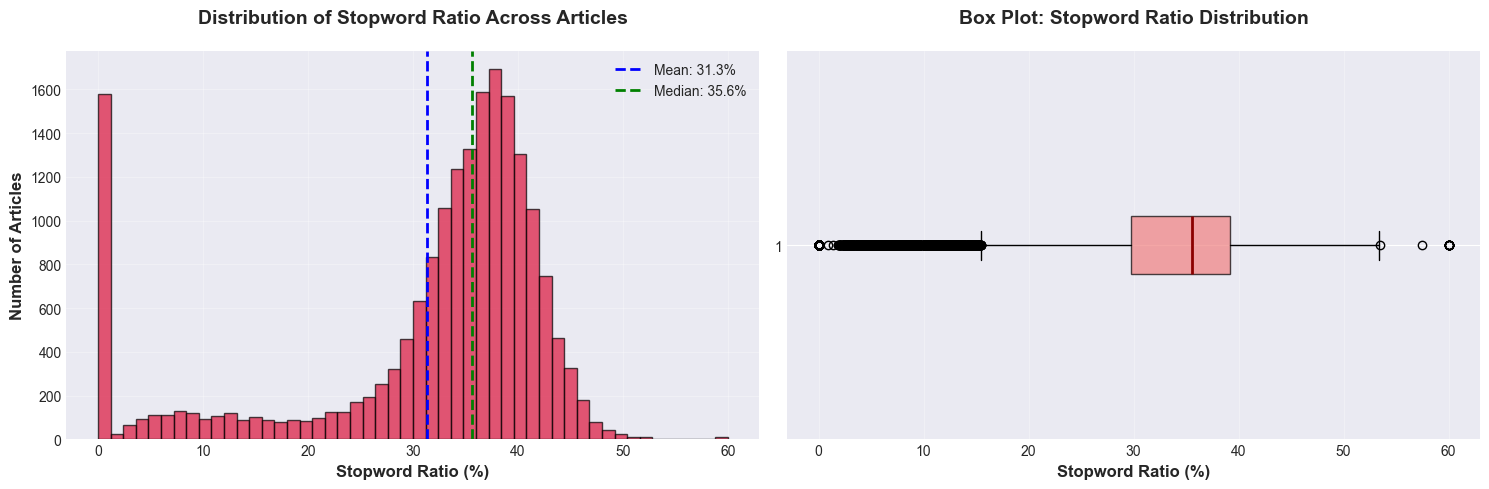

In [35]:
# Visualize stopword ratio distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df_with_text['stopword_ratio'], bins=50, color='crimson', 
             edgecolor='black', alpha=0.7)
axes[0].axvline(df_with_text['stopword_ratio'].mean(), color='blue', 
                linestyle='--', linewidth=2, 
                label=f"Mean: {df_with_text['stopword_ratio'].mean():.1f}%")
axes[0].axvline(df_with_text['stopword_ratio'].median(), color='green', 
                linestyle='--', linewidth=2, 
                label=f"Median: {df_with_text['stopword_ratio'].median():.1f}%")
axes[0].set_xlabel('Stopword Ratio (%)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Articles', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Stopword Ratio Across Articles', 
                  fontsize=14, fontweight='bold', pad=20)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df_with_text['stopword_ratio'], vert=False, patch_artist=True,
                boxprops=dict(facecolor='lightcoral', alpha=0.7),
                medianprops=dict(color='darkred', linewidth=2))
axes[1].set_xlabel('Stopword Ratio (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Box Plot: Stopword Ratio Distribution', 
                  fontsize=14, fontweight='bold', pad=20)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../results/figures/stopword_ratio_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to results/figures/stopword_ratio_distribution.png")
plt.show()

✓ Figure saved to results/figures/stopword_ratio_vs_length.png


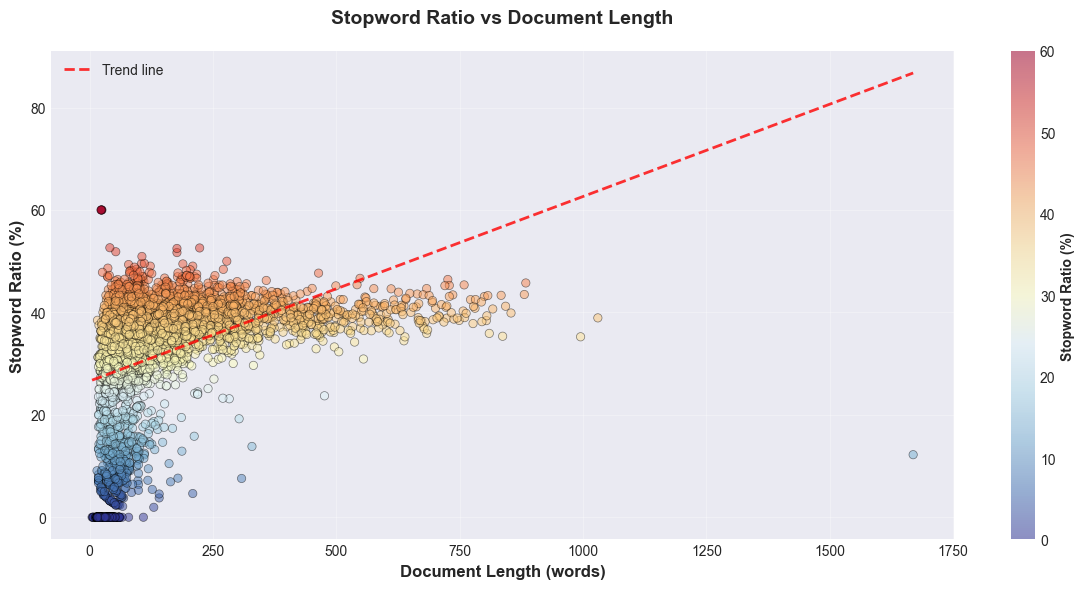


📊 Correlation between document length and stopword ratio: 0.392


In [36]:
# Stopword ratio vs document length
fig, ax = plt.subplots(figsize=(12, 6))

# Sample for better visualization (plot every 10th point if dataset is large)
sample_size = min(5000, len(df_with_text))
sample_df = df_with_text.sample(n=sample_size, random_state=42)

scatter = ax.scatter(sample_df['body_word_count'], 
                     sample_df['stopword_ratio'],
                     alpha=0.5, 
                     c=sample_df['stopword_ratio'],
                     cmap='RdYlBu_r',
                     edgecolors='black',
                     linewidth=0.5)

ax.set_xlabel('Document Length (words)', fontsize=12, fontweight='bold')
ax.set_ylabel('Stopword Ratio (%)', fontsize=12, fontweight='bold')
ax.set_title('Stopword Ratio vs Document Length', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Stopword Ratio (%)', fontweight='bold')

# Add trend line
z = np.polyfit(sample_df['body_word_count'], sample_df['stopword_ratio'], 1)
p = np.poly1d(z)
ax.plot(sample_df['body_word_count'].sort_values(), 
        p(sample_df['body_word_count'].sort_values()),
        "r--", linewidth=2, alpha=0.8, label='Trend line')
ax.legend()

plt.tight_layout()
plt.savefig('../results/figures/stopword_ratio_vs_length.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to results/figures/stopword_ratio_vs_length.png")
plt.show()

# Calculate correlation
correlation = df_with_text['body_word_count'].corr(df_with_text['stopword_ratio'])
print(f"\n📊 Correlation between document length and stopword ratio: {correlation:.3f}")

---
# Summary of Key Findings
## Insights from Exploratory Data Analysis

In [37]:
print("="*70)
print("KEY FINDINGS - REUTERS-21578 EXPLORATORY DATA ANALYSIS")
print("="*70)

print("\n1️⃣ DATASET CHARACTERISTICS:")
print(f"   • Total articles: {total_articles:,}")
print(f"   • Articles with topic labels: {articles_with_topics:,}")
print(f"   • Unique topics: {unique_topics}")
print(f"   • Topics with ≥20 docs (suitable for classification): {len(frequent_topics)}")

print("\n2️⃣ TEXT LENGTH CHARACTERISTICS:")
print(f"   • Average article length: {df_with_text['body_word_count'].mean():.0f} words")
print(f"   • Median article length: {df_with_text['body_word_count'].median():.0f} words")
print(f"   • Length range: {df_with_text['body_word_count'].min():.0f} - {df_with_text['body_word_count'].max():.0f} words")

print("\n3️⃣ VOCABULARY STATISTICS:")
print(f"   • Total words in corpus: {len(all_words):,}")
print(f"   • Unique words (vocabulary size): {len(set(all_words)):,}")
print(f"   • Vocabulary diversity: {len(set(all_words))/len(all_words)*100:.2f}%")

print("\n4️⃣ STOPWORD ANALYSIS:")
print(f"   • Stopword proportion: {stopword_percentage:.2f}%")
print(f"   • Average stopword ratio per article: {df_with_text['stopword_ratio'].mean():.2f}%")
print(f"   • Stopwords in top 30 most frequent words: {sum(1 for w in word_freq_df.head(30)['Word'] if w in english_stopwords)}")
print(f"   • Potential feature reduction by removing stopwords: ~{stopword_percentage:.1f}%")

print("\n5️⃣ RESEARCH IMPLICATIONS:")
print("   • High stopword ratio suggests significant potential for feature reduction")
print("   • Diverse vocabulary indicates rich semantic content")
print("   • Varied document lengths may require length-aware preprocessing")
print("   • Multi-label nature of dataset requires appropriate evaluation metrics")

print("\n" + "="*70)
print("✓ Exploratory Data Analysis Complete")
print("="*70)

KEY FINDINGS - REUTERS-21578 EXPLORATORY DATA ANALYSIS

1️⃣ DATASET CHARACTERISTICS:
   • Total articles: 21,578
   • Articles with topic labels: 11,367
   • Unique topics: 120
   • Topics with ≥20 docs (suitable for classification): 57

2️⃣ TEXT LENGTH CHARACTERISTICS:
   • Average article length: 136 words
   • Median article length: 90 words
   • Length range: 2 - 1669 words

3️⃣ VOCABULARY STATISTICS:
   • Total words in corpus: 2,490,826
   • Unique words (vocabulary size): 38,858
   • Vocabulary diversity: 1.56%

4️⃣ STOPWORD ANALYSIS:
   • Stopword proportion: 36.74%
   • Average stopword ratio per article: 31.32%
   • Stopwords in top 30 most frequent words: 22
   • Potential feature reduction by removing stopwords: ~36.7%

5️⃣ RESEARCH IMPLICATIONS:
   • High stopword ratio suggests significant potential for feature reduction
   • Diverse vocabulary indicates rich semantic content
   • Varied document lengths may require length-aware preprocessing
   • Multi-label nature of da

In [39]:
# Create comprehensive summary report
summary_report = f"""
REUTERS-21578 DATASET - EXPLORATORY DATA ANALYSIS SUMMARY
=========================================================

Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}

DATASET OVERVIEW
----------------
Total Articles: {total_articles:,}
Articles with Topics: {articles_with_topics:,} ({articles_with_topics/total_articles*100:.1f}%)
Articles with Body Text: {articles_with_body:,} ({articles_with_body/total_articles*100:.1f}%)
Unique Topics: {unique_topics}
Topics with ≥20 documents: {len(frequent_topics)}

TEXT STATISTICS
---------------
Average Article Length: {df_with_text['body_word_count'].mean():.0f} words
Median Article Length: {df_with_text['body_word_count'].median():.0f} words
Standard Deviation: {df_with_text['body_word_count'].std():.0f} words
Range: {df_with_text['body_word_count'].min():.0f} - {df_with_text['body_word_count'].max():.0f} words

VOCABULARY ANALYSIS
-------------------
Total Words: {len(all_words):,}
Unique Words: {len(set(all_words)):,}
Vocabulary Diversity: {len(set(all_words))/len(all_words)*100:.2f}%

STOPWORD ANALYSIS
-----------------
Stopwords in Corpus: {stopword_count:,} ({stopword_percentage:.2f}%)
Non-stopwords: {non_stopword_count:,} ({100-stopword_percentage:.2f}%)
Average Stopword Ratio per Article: {df_with_text['stopword_ratio'].mean():.2f}%
NLTK Stopword List Size: {len(english_stopwords)} words

TOP 10 TOPICS BY FREQUENCY
--------------------------
{topic_df.head(10).to_string(index=False)}

TOP 10 MOST FREQUENT WORDS
--------------------------
{word_freq_df.head(10).to_string(index=False)}

TOP 10 MOST FREQUENT STOPWORDS
------------------------------
{stopword_freq_df.head(10).to_string(index=False)}

KEY INSIGHTS FOR PROJECT
------------------------
1. Stopwords constitute approximately {stopword_percentage:.1f}% of the corpus
2. Removing stopwords could reduce feature space by ~{stopword_percentage:.1f}%
3. Document length varies significantly (CV: {(df_with_text['body_word_count'].std()/df_with_text['body_word_count'].mean())*100:.1f}%)
4. Multi-label classification task with {len(frequent_topics)} viable categories
5. Rich vocabulary ({len(set(all_words)):,} unique words) suitable for text classification

FILES GENERATED
---------------
Tables:
  - dataset_summary.csv
  - topic_distribution.csv
  - text_length_statistics.csv
  - word_frequencies.csv
  - stopword_frequencies.csv

Figures:
  - top_20_topics.png
  - topic_frequency_distribution.png
  - text_length_distribution.png
  - length_categories.png
  - top_30_words.png
  - zipf_law.png
  - stopword_analysis.png
  - stopword_ratio_distribution.png
  - stopword_ratio_vs_length.png

=========================================================
"""

# Save summary report
with open('../results/tables/eda_summary_report.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)

print(summary_report)
print("\n✓ Summary report saved to results/tables/eda_summary_report.txt")


REUTERS-21578 DATASET - EXPLORATORY DATA ANALYSIS SUMMARY

Analysis Date: 2026-02-15

DATASET OVERVIEW
----------------
Total Articles: 21,578
Articles with Topics: 11,367 (52.7%)
Articles with Body Text: 19,043 (88.3%)
Unique Topics: 120
Topics with ≥20 documents: 57

TEXT STATISTICS
---------------
Average Article Length: 136 words
Median Article Length: 90 words
Standard Deviation: 135 words
Range: 2 - 1669 words

VOCABULARY ANALYSIS
-------------------
Total Words: 2,490,826
Unique Words: 38,858
Vocabulary Diversity: 1.56%

STOPWORD ANALYSIS
-----------------
Stopwords in Corpus: 915,202 (36.74%)
Non-stopwords: 1,575,624 (63.26%)
Average Stopword Ratio per Article: 31.32%
NLTK Stopword List Size: 198 words

TOP 10 TOPICS BY FREQUENCY
--------------------------
   Topic  Count
    earn   3987
     acq   2448
money-fx    801
   crude    634
   grain    628
   trade    552
interest    513
   wheat    306
    ship    305
    corn    254

TOP 10 MOST FREQUENT WORDS
--------------------

In [42]:
# Save processed data for next steps
df_with_text.to_csv('../data/processed/reuters_with_analysis.csv', index=False)
print("✓ Processed data with analysis saved to data/processed/reuters_with_analysis.csv")

print("\n" + "="*70)
print("🎉 EXPLORATORY DATA ANALYSIS COMPLETE!")
print("="*70)


✓ Processed data with analysis saved to data/processed/reuters_with_analysis.csv

🎉 EXPLORATORY DATA ANALYSIS COMPLETE!
